# Fraud Detection

## Import required modules

In [73]:
get_ipython().magic(u'matplotlib inline')
from __future__ import division
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from operator import itemgetter
from itertools import groupby
import numpy as np
import pandas as pd
import seaborn as sns

## Read and preview data

We read the `data_for_student_case.csv` file and preview the data.

In [74]:
data = pd.read_csv('data/data_for_student_case.csv')
data.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


In [75]:
data.dtypes

txid                              int64
bookingdate                      object
issuercountrycode                object
txvariantcode                    object
bin                             float64
amount                          float64
currencycode                     object
shoppercountrycode               object
shopperinteraction               object
simple_journal                   object
cardverificationcodesupplied     object
cvcresponsecode                   int64
creationdate                     object
accountcode                      object
mail_id                          object
ip_id                            object
card_id                          object
dtype: object

In [76]:
for x in data.columns:
    unique_values = set(data[x])
    if len(unique_values) < 100:
        print x,": ", unique_values


txvariantcode :  set(['visasignature', 'visaplatinum', 'mc', 'visacorporate', 'visagold', 'visaclassic', 'mcdebit', 'electron', 'visa', 'visabusiness', 'visadebit', 'visapurchasing', 'vpay', 'mccredit', 'cirrus'])
currencycode :  set(['MXN', 'SEK', 'AUD', 'GBP', 'NZD'])
shopperinteraction :  set(['ContAuth', 'Ecommerce', 'POS'])
simple_journal :  set(['Refused', 'Settled', 'Chargeback'])
cardverificationcodesupplied :  set([False, True, nan])
cvcresponsecode :  set([0, 1, 2, 3, 5])
accountcode :  set(['UKAccount', 'APACAccount', 'SwedenAccount', 'MexicoAccount'])


In [77]:
data.describe() #the only relevant desciption is the amount attribute

,txid,bin,amount,cvcresponsecode
count,290382.000000,290242.000000,2.903820e+05,290382.000000
mean,279916.750673,485254.586238,2.936462e+04,0.769004
std,138437.214796,37015.528140,6.829927e+04,0.508933
min,1.000000,400000.000000,5.000000e+01,0.000000
25%,218232.250000,462239.000000,4.400000e+03,0.000000
50%,304071.500000,475139.000000,7.095000e+03,1.000000
75%,387592.750000,518652.000000,1.589500e+04,1.000000
max,482734.000000,676883.000000,2.785840e+06,5.000000


## Preprocessing

Some preprocessing steps that we try to apply are:
* Remove the `refused` transactions, because their fraudulent ambiguity
* Transform creationdate to pandas datetime
* Reduce the possible number of CVC response code (as it is 0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked) to 0, 1, and 3
* Map float columns which supposed to be categorical / identifier (`bin` and `cvcresponsecode`)
* Convert to EURO
* Assign fraudulent label based on `simple_journal` attribute (fraudulent = 1 if simple_journal='chargeback', else fraudulent = 0)

### Remove 'refused' transactions

In [78]:
data_preproc = data.loc[data['simple_journal'] != 'Refused'].copy()
data_preproc.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


### Transform date to pandas datetime

In [79]:
data_preproc['creationdate'] = pd.to_datetime(data_preproc['creationdate'])
# save month, date, and weekday
data_preproc['creation_month'] = data_preproc.creationdate.dt.month
data_preproc['creation_weekday'] = data_preproc.creationdate.dt.weekday
data_preproc['creation_day'] = data_preproc.creationdate.dt.day

# don't need to process booking date, will be removed anyway:
# data_preproc['bookingdate'] = pd.to_datetime(data_preproc['bookingdate'])
# convert datetime to timestamp
# data_preproc['ts'] = data_preproc.creationdate.values.astype(np.int64) // 10 ** 9
# print (data_preproc)

### Map cvcresponsecode with value 3-6 to 3

In [80]:
data_preproc['cvcresponsecode'] = map(lambda x: 3 if int(x) >= 3 else int(x), data_preproc['cvcresponsecode'])

### Map to categorical and object (for identifier) datatype

In [81]:
data_preproc['bin'] = data_preproc['bin'].astype(int)
data_preproc['bin'] = data_preproc['bin'].astype(str)
data_preproc['txid'] = data_preproc['txid'].astype(str)
for category_column in ["issuercountrycode","txvariantcode", "bin", "currencycode","shopperinteraction","simple_journal","cardverificationcodesupplied","cvcresponsecode","accountcode"]:  
    data_preproc[category_column] = data_preproc[category_column].astype("category")
data_preproc.dtypes

txid                                    object
bookingdate                             object
issuercountrycode                     category
txvariantcode                         category
bin                                   category
amount                                 float64
currencycode                          category
shoppercountrycode                      object
shopperinteraction                    category
simple_journal                        category
cardverificationcodesupplied          category
cvcresponsecode                       category
creationdate                    datetime64[ns]
accountcode                           category
mail_id                                 object
ip_id                                   object
card_id                                 object
creation_month                           int64
creation_weekday                         int64
creation_day                             int64
dtype: object

### Convert amount to EURO currencies

In [82]:
from currency_converter import CurrencyConverter

currency_converter = CurrencyConverter()
data_preproc['amount_euro'] = map(lambda x,y: currency_converter.convert(x,y, 'EUR'), data_preproc['amount'],data_preproc['currencycode'])
data_preproc.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,...,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,creation_month,creation_weekday,creation_day,amount_euro
0,1,2015-11-09 14:26:51,MX,mccredit,530056,64800.0,MXN,MX,Ecommerce,Chargeback,...,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,7,2,1,2809.743914
1,2,2015-11-09 14:27:38,MX,mccredit,547046,44900.0,MXN,MX,Ecommerce,Chargeback,...,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,7,3,2,1946.875027
2,3,2015-11-23 16:34:16,MX,mccredit,528843,149900.0,MXN,MX,Ecommerce,Chargeback,...,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,7,3,2,6499.700814
3,4,2015-11-23 16:34:51,MX,mccredit,547146,109900.0,MXN,MX,Ecommerce,Chargeback,...,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,7,4,3,4765.290991
4,5,2015-11-09 14:26:08,MX,visaclassic,477291,89900.0,MXN,MX,Ecommerce,Chargeback,...,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,7,2,8,3898.086079


### Apply fraudulent label

In [83]:
data_preproc['is_fraud'] = data_preproc.apply(lambda x: 1 if x['simple_journal'] == "Chargeback" else 0, axis=1)
# remove the simple_journal column
data_preproc = data_preproc.drop(['simple_journal'],axis=1)
data_preproc.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,...,creationdate,accountcode,mail_id,ip_id,card_id,creation_month,creation_weekday,creation_day,amount_euro,is_fraud
0,1,2015-11-09 14:26:51,MX,mccredit,530056,64800.0,MXN,MX,Ecommerce,True,...,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,7,2,1,2809.743914,1
1,2,2015-11-09 14:27:38,MX,mccredit,547046,44900.0,MXN,MX,Ecommerce,True,...,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,7,3,2,1946.875027,1
2,3,2015-11-23 16:34:16,MX,mccredit,528843,149900.0,MXN,MX,Ecommerce,True,...,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,7,3,2,6499.700814,1
3,4,2015-11-23 16:34:51,MX,mccredit,547146,109900.0,MXN,MX,Ecommerce,True,...,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,7,4,3,4765.290991,1
4,5,2015-11-09 14:26:08,MX,visaclassic,477291,89900.0,MXN,MX,Ecommerce,True,...,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,7,2,8,3898.086079,1


In [84]:
data_preproc['is_fraud'] = data_preproc['is_fraud'].astype("category")
data_preproc.dtypes

txid                                    object
bookingdate                             object
issuercountrycode                     category
txvariantcode                         category
bin                                   category
amount                                 float64
currencycode                          category
shoppercountrycode                      object
shopperinteraction                    category
cardverificationcodesupplied          category
cvcresponsecode                       category
creationdate                    datetime64[ns]
accountcode                           category
mail_id                                 object
ip_id                                   object
card_id                                 object
creation_month                           int64
creation_weekday                         int64
creation_day                             int64
amount_euro                            float64
is_fraud                              category
dtype: object

### Remove bookingdate
Certain bookingdate indicates that the transaction is indeed fraudulent, so we may not use it for training our classifier

In [85]:
data_preproc = data_preproc.drop(['bookingdate'],axis=1)
data_preproc.head()

,txid,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,creation_month,creation_weekday,creation_day,amount_euro,is_fraud
0,1,MX,mccredit,530056,64800.0,MXN,MX,Ecommerce,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,7,2,1,2809.743914,1
1,2,MX,mccredit,547046,44900.0,MXN,MX,Ecommerce,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,7,3,2,1946.875027,1
2,3,MX,mccredit,528843,149900.0,MXN,MX,Ecommerce,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,7,3,2,6499.700814,1
3,4,MX,mccredit,547146,109900.0,MXN,MX,Ecommerce,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,7,4,3,4765.290991,1
4,5,MX,visaclassic,477291,89900.0,MXN,MX,Ecommerce,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,7,2,8,3898.086079,1


## Visualization Task
We try the following visualization:
* Distribution histogram
* Line chart
* Heat map

### Distribution histogram

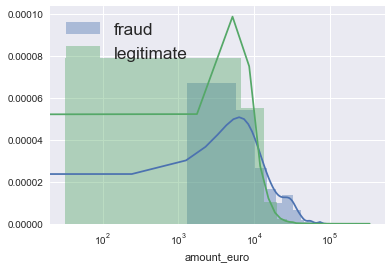

In [86]:
fraud = data_preproc.loc[data_preproc['is_fraud'] == 1]
non_fraud = data_preproc.loc[data_preproc['is_fraud'] == 0]
plt.figure("Amount Distribution (Fraud")
fraud_plot = sns.distplot(fraud['amount_euro'], label="fraud")
fraud_plot.set_xscale('log')
non_fraud_plot = sns.distplot(non_fraud['amount_euro'], label="legitimate")
non_fraud_plot.set_xscale('log')
plt.legend(fontsize="xx-large")
plt.show()

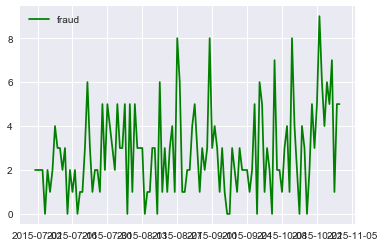

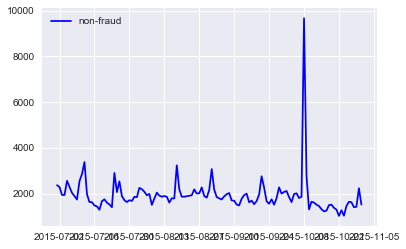

In [87]:
temp_fraud = fraud.set_index('creationdate').resample('1D').count()['txid']
x_fraud = temp_fraud.index
y_fraud = temp_fraud.values

temp_non_fraud = non_fraud.set_index('creationdate').resample('1D').count()['txid']
x_non_fraud = temp_non_fraud.index
y_non_fraud = temp_non_fraud.values


plt.figure()
plt.plot(x_fraud, y_fraud, 'g', label="fraud");
plt.legend()
plt.show()

plt.figure()
plt.plot(x_non_fraud, y_non_fraud,  'b', label="non-fraud");
plt.legend()
plt.show()

### Heat map

We try to plot a heat map in regards of percentage of fraudulent transaction

In [88]:
import itertools

def fraud_heatmap(column_name_a, column_name_b, frac=True):
    # column_name_a = 'currencycode'
    # column_name_b = 'accountcode'

    x_axis = list(data_preproc[column_name_a].unique())
    y_axis = list(data_preproc[column_name_b].unique())
    values = []

    length_x = len(x_axis)
    length_y = len(y_axis)
    x_axis = np.repeat(x_axis, length_y)
    y_axis = y_axis*length_x


    for combination in zip(x_axis, y_axis):
        # number of fraud
        num_fraud = len(fraud.loc[(fraud[column_name_a] == combination[0]) & (fraud[column_name_b] == combination[1])])
        num_total = len(data_preproc.loc[(data_preproc[column_name_a] == combination[0]) & (data_preproc[column_name_b] == combination[1])])
        #num_total = len(data_preproc)
        
        if frac:
            if num_total == 0:
                values.append(0)
            else:
                values.append(num_fraud / float(num_total))
        else: 
            values.append(num_fraud)

    df = pd.DataFrame({column_name_a: x_axis, column_name_b: y_axis, 'value': values })

    # plot it
    df_wide=df.pivot_table( index=column_name_a, columns=column_name_b, values='value' )
    sns.set(rc={"figure.figsize": (10, 10)})
    sns.heatmap( df_wide, cmap="Blues", annot=True)

In [89]:
# select categorical columns
categorical_columns = [x for x in data_preproc.columns if hasattr(data_preproc[x], 'cat') and x != 'issuercountrycode' and x != 'bin']
# remove is_fraud
categorical_columns = categorical_columns[:-1]

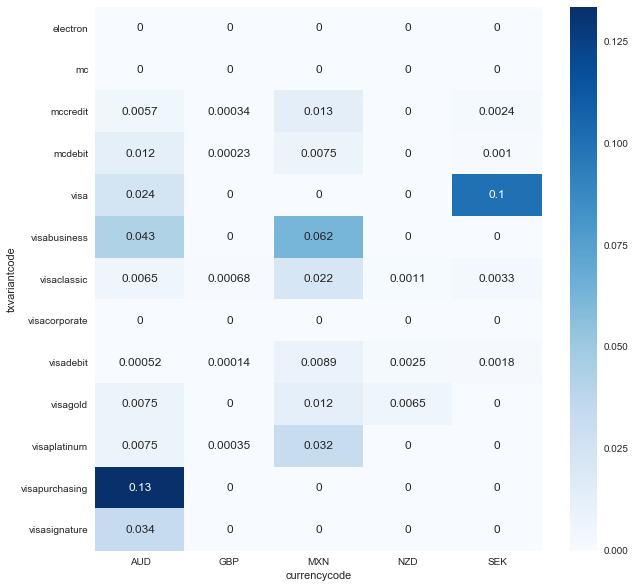

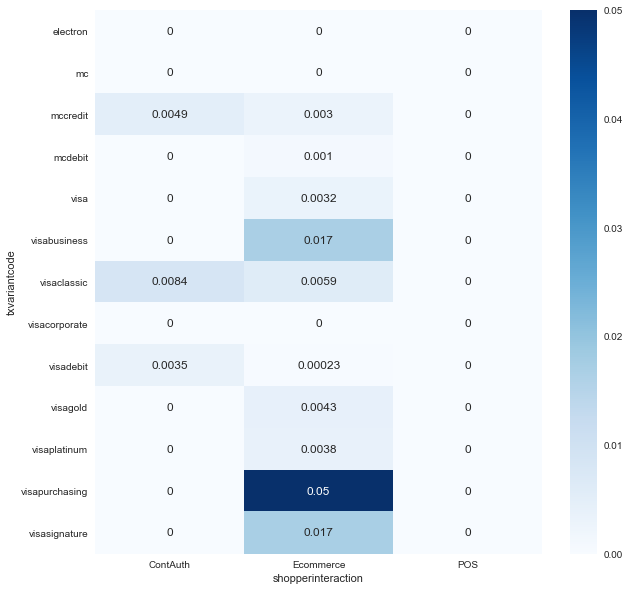

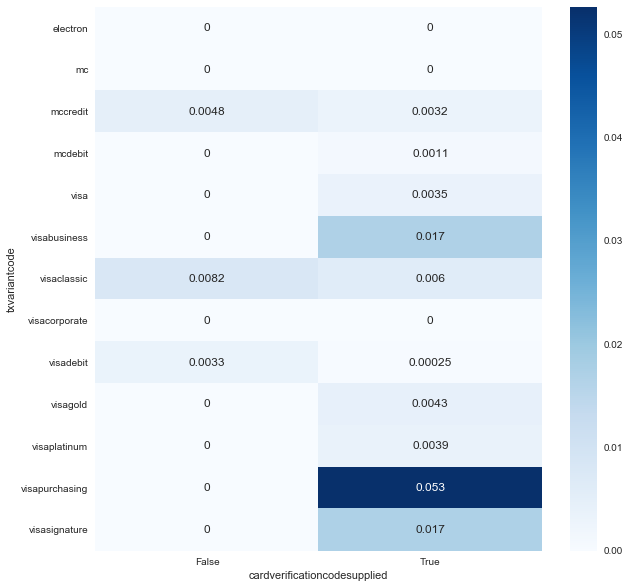

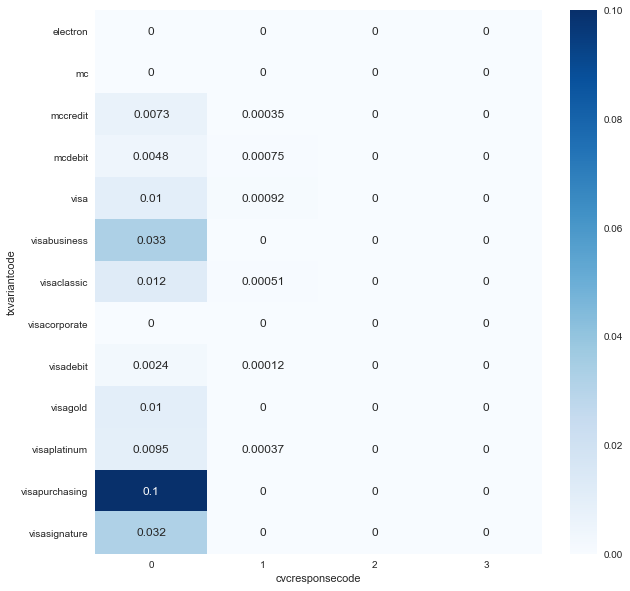

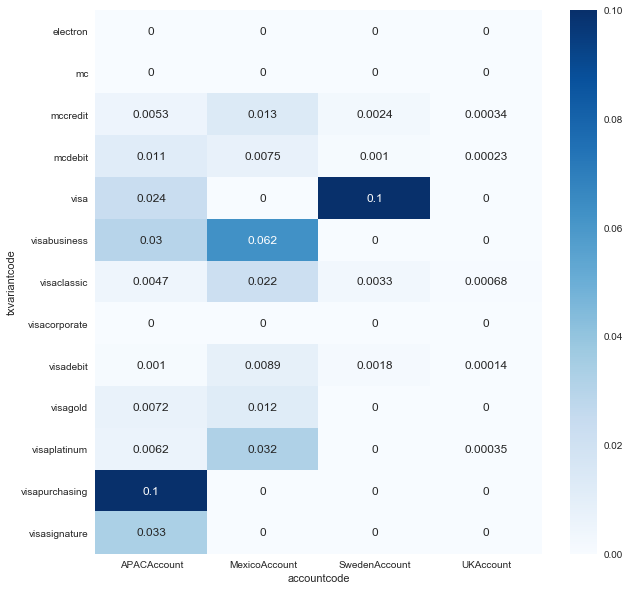

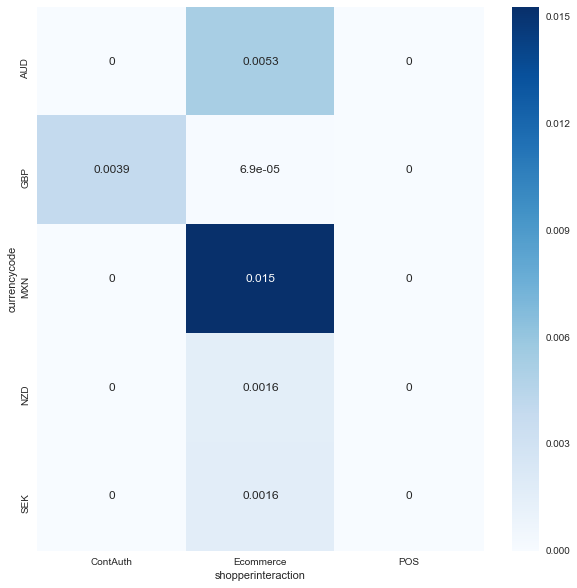

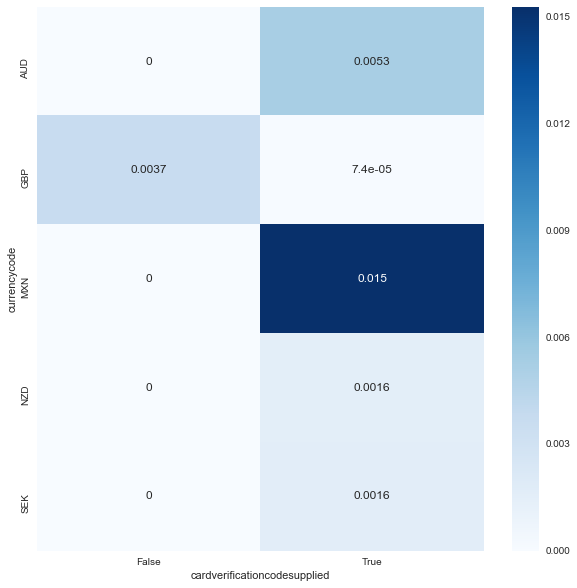

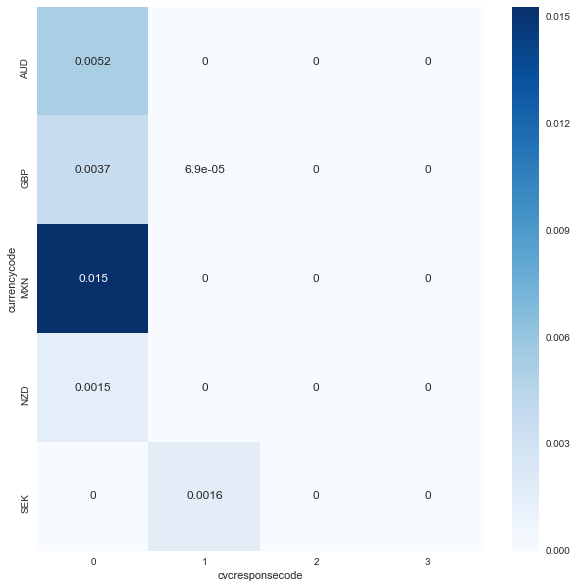

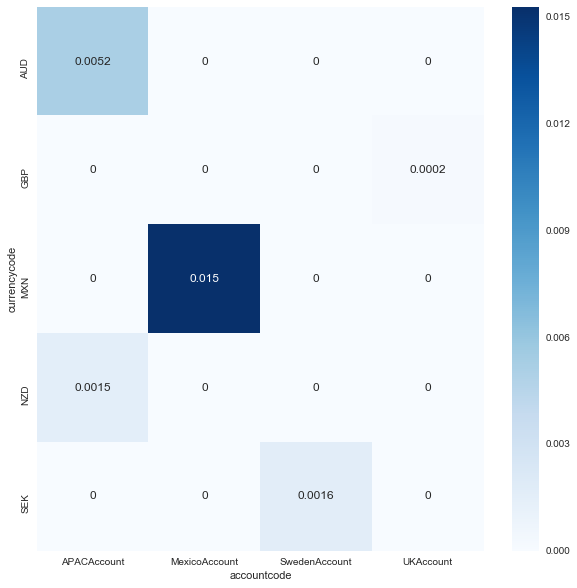

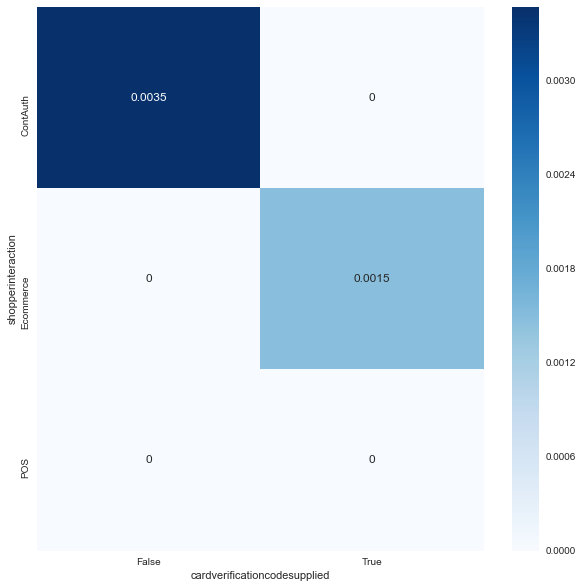

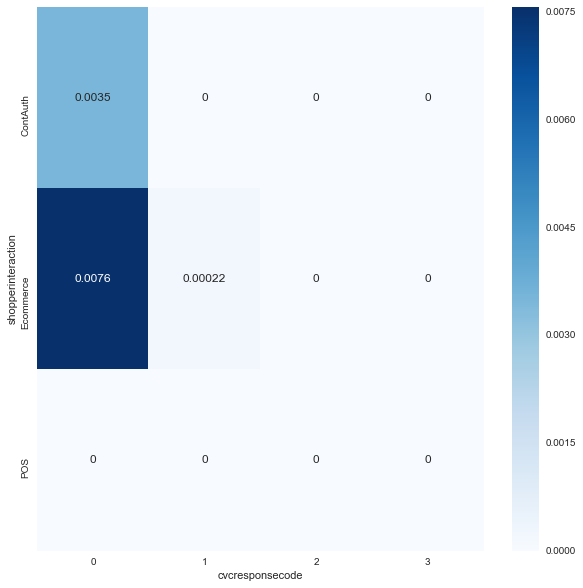

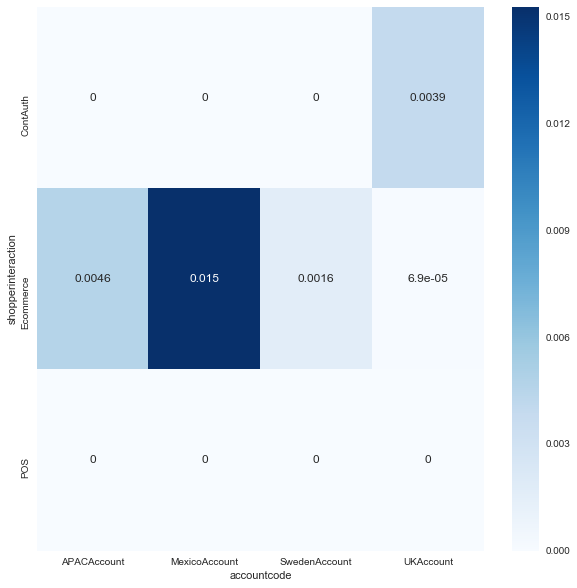

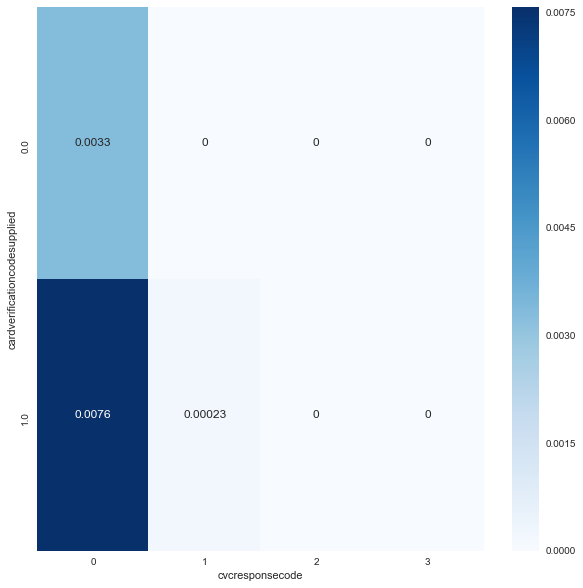

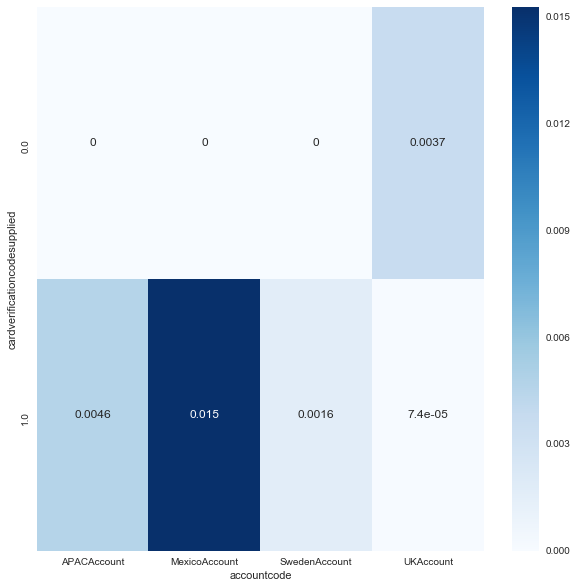

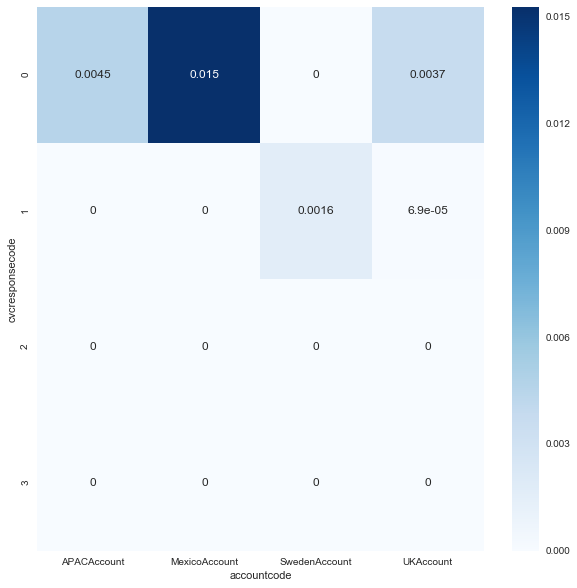

In [90]:
for combination in list(itertools.combinations(categorical_columns,2)):
    fraud_heatmap(combination[0], combination[1], frac=True)
    plt.show()

In [91]:
data_preproc.loc[(data_preproc['cvcresponsecode'] == 0) & (data_preproc['txvariantcode'] == 'visapurchasing')]

,txid,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,creation_month,creation_weekday,creation_day,amount_euro,is_fraud
27941,45118,AU,visapurchasing,471514,51000.0,AUD,AU,Ecommerce,True,0,2015-08-16 13:32:46,APACAccount,email35874,ip118330,card23723,8,6,16,32494.424976,1
28013,45192,AU,visapurchasing,471514,8850.0,AUD,AU,Ecommerce,True,0,2015-10-20 15:51:28,APACAccount,email236905,ip476,card176079,10,1,20,5638.738452,1
35649,57146,AU,visapurchasing,471527,20000.0,AUD,AU,Ecommerce,True,0,2015-07-20 02:10:06,APACAccount,email186084,ip114785,card155227,7,0,20,12742.911755,0
35650,57147,AU,visapurchasing,471527,20000.0,AUD,AU,Ecommerce,NaN,0,2015-07-20 02:13:48,APACAccount,email178263,ip114785,card155227,7,0,20,12742.911755,0
37439,60143,AU,visapurchasing,471527,13850.0,AUD,AU,Ecommerce,True,0,2015-07-28 03:57:07,APACAccount,email256164,ip55206,card75701,7,1,28,8824.466391,0
39391,63383,AU,visapurchasing,471572,200.0,AUD,AU,Ecommerce,True,0,2015-08-05 16:06:23,APACAccount,email246611,ip28166,card170596,8,2,5,127.429118,0
42732,69038,AU,visapurchasing,471527,23800.0,AUD,AU,Ecommerce,True,0,2015-08-19 07:36:46,APACAccount,email55647,ip33774,card60335,8,2,19,15164.064989,0
43114,69632,AU,visapurchasing,471527,16000.0,AUD,AU,Ecommerce,True,0,2015-08-21 03:48:30,APACAccount,email146139,ip6867,card82334,8,4,21,10194.329404,0
43655,70510,AU,visapurchasing,471527,14850.0,AUD,AU,Ecommerce,True,0,2015-08-24 01:29:23,APACAccount,email55647,ip33774,card60335,8,0,24,9461.611978,0
44298,71536,NZ,visapurchasing,471540,9250.0,NZD,NZ,Ecommerce,True,0,2015-08-27 02:18:55,APACAccount,email160445,ip35970,card61719,8,3,27,5488.637038,0


## Imbalance Task

First let's see how imbalance is the fraud vs non-fraud transactions

In [92]:
data_preproc.is_fraud.value_counts()

0    236691
1       345
Name: is_fraud, dtype: int64

Let's try to do classification without any balancing method. First we need to encode the categorical value:

In [93]:
data_preproc.dtypes

txid                                    object
issuercountrycode                     category
txvariantcode                         category
bin                                   category
amount                                 float64
currencycode                          category
shoppercountrycode                      object
shopperinteraction                    category
cardverificationcodesupplied          category
cvcresponsecode                       category
creationdate                    datetime64[ns]
accountcode                           category
mail_id                                 object
ip_id                                   object
card_id                                 object
creation_month                           int64
creation_weekday                         int64
creation_day                             int64
amount_euro                            float64
is_fraud                              category
dtype: object

In [94]:
# remove identifiers
temp = data_preproc.copy()
for x in data_preproc.columns:
    if data_preproc[x].dtypes == np.dtype('O'):
        temp = temp.drop([x], axis=1)
        
temp = temp.drop(['creationdate'], axis=1)
print temp.dtypes

issuercountrycode               category
txvariantcode                   category
bin                             category
amount                           float64
currencycode                    category
shopperinteraction              category
cardverificationcodesupplied    category
cvcresponsecode                 category
accountcode                     category
creation_month                     int64
creation_weekday                   int64
creation_day                       int64
amount_euro                      float64
is_fraud                        category
dtype: object


In [95]:
# remove bin column as it has too many unique values
temp = temp.drop(['bin'], axis=1)

In [96]:
# separate labels
labels = temp['is_fraud']
temp = temp.drop(['is_fraud'], axis=1)

temp = pd.get_dummies(temp, dummy_na=True)
temp.head()

feature_names = temp.columns

labels = np.array(labels)
temp = np.array(temp)

len(feature_names)

159

In [114]:
# create train test split
X_train, X_test, y_train, y_test = train_test_split(temp, labels, test_size=0.40, random_state=42)

In [115]:
print "Training Data"
print "Fraud: ", len([x for x in y_train if x == 1])
print "Non-Fraud: ", len([x for x in y_train if x == 0])
    
print "Test Data"
print "Fraud: ", len([x for x in y_test if x == 1])
print "Non-Fraud: ", len([x for x in y_test if x == 0])

Training Data
Fraud:  208
Non-Fraud:  142013
Test Data
Fraud:  137
Non-Fraud:  94678


In [116]:
# loading library
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.metrics import recall_score,accuracy_score

# instantiate learning model (k = 3)
clf = KNeighborsClassifier(n_neighbors=3)
# clf = tree.DecisionTreeClassifier()

# fitting the model
clf.fit(X_train, y_train)

# predict the response
pred = clf.predict(X_test)

# evaluate accuracy
print recall_score(y_test, pred)
print accuracy_score(y_test, pred)

0.021897810218978103
0.9984390655487001


Ha! Accuracy of **99%** but recall of **2.6%** >:D Let's try it out with SMOTE

In [107]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

print "Training Data (SMOTE)"
print "Fraud: ", len([x for x in y_train_res if x == 1])
print "Non-Fraud: ", len([x for x in y_train_res if x == 0])

Training Data (SMOTE)
Fraud:  158582
Non-Fraud:  158582


In [108]:
clf.fit(X_train_res, y_train_res)
pred = clf.predict(X_test)

print recall_score(y_test, pred)
print accuracy_score(y_test, pred)

0.24778761061946902
0.9631561453299583


Improvement of recall! It became **24.7%** from the previous **2.6%**. Let's try to plot the ROC curve.

0.6486899915332749


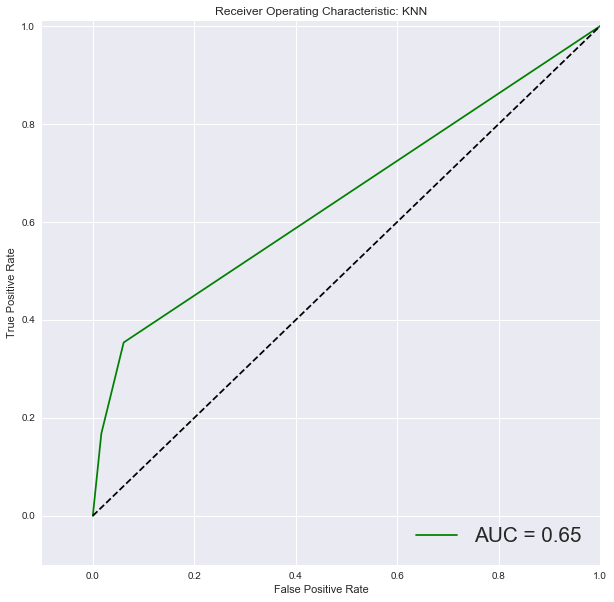

In [109]:
from sklearn.metrics import roc_curve, roc_auc_score
pred_proba = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, pred_proba, pos_label=1)
auc_score = roc_auc_score(y_test, pred_proba)
print auc_score

plt.title('Receiver Operating Characteristic: KNN')

plt.plot(fpr, tpr, 'g',label='AUC = %0.2f'% auc_score)

plt.legend(loc='lower right', fontsize="xx-large")
plt.plot([0,1],[0,1],'k--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [123]:
# from https://www.kaggle.com/lct14558/imbalanced-data-why-you-should-not-use-roc-curve
def PlotConfusionMatrix(y_test,pred,y_test_legit,y_test_fraud):

    cfn_matrix = confusion_matrix(y_test,pred)
    cfn_norm_matrix = np.array([[1.0 / y_test_legit,1.0/y_test_legit],[1.0/y_test_fraud,1.0/y_test_fraud]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)

    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('---Classification Report---')
    print(classification_report(y_test,pred))

In [128]:
y_test_legit = len(y_test[y_test == 0])
y_test_fraud = len(y_test[y_test == 1])

94678
137


Now let's try to compare ROC curve with these classifiers: KNN, Logistic Regression, and RandomForest, each without and with SMOTE

Without SMOTE
0.5601389141805734


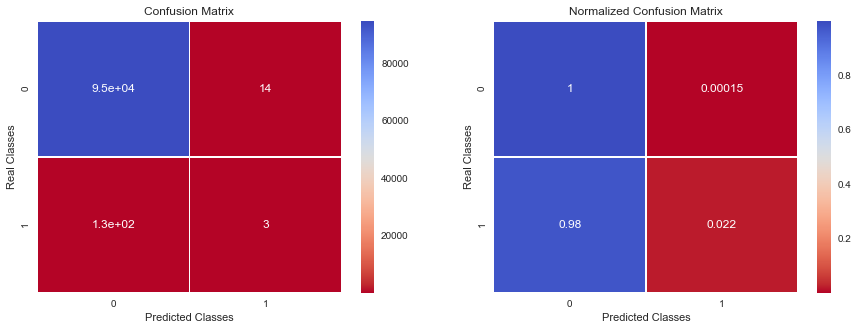

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     94678
          1       0.18      0.02      0.04       137

avg / total       1.00      1.00      1.00     94815

With SMOTE
0.7052720608291523


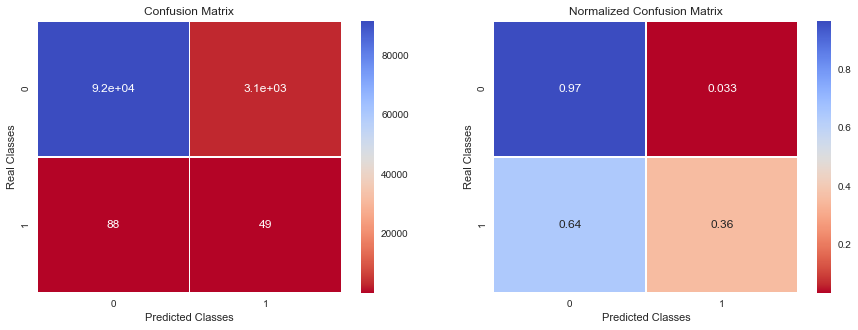

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.97      0.98     94678
          1       0.02      0.36      0.03       137

avg / total       1.00      0.97      0.98     94815

Without SMOTE
0.7523198877856146


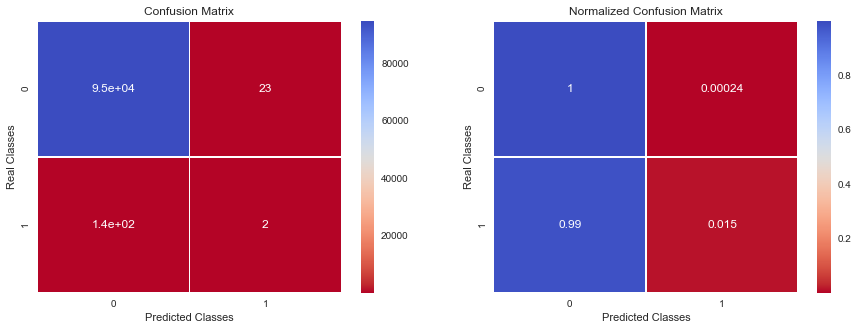

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     94678
          1       0.08      0.01      0.02       137

avg / total       1.00      1.00      1.00     94815

With SMOTE
0.8075774469068653


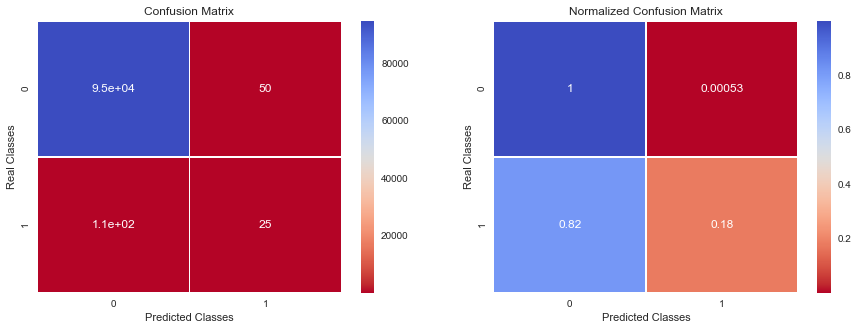

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     94678
          1       0.33      0.18      0.24       137

avg / total       1.00      1.00      1.00     94815

Without SMOTE
0.9043207225782418


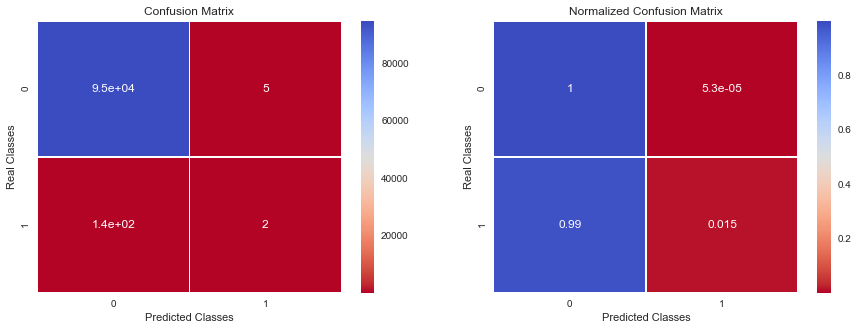

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     94678
          1       0.29      0.01      0.03       137

avg / total       1.00      1.00      1.00     94815

With SMOTE
0.8900146065581025


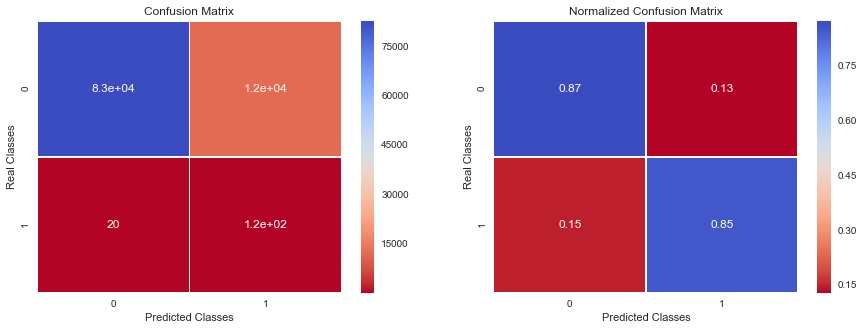

---Classification Report---
             precision    recall  f1-score   support

          0       1.00      0.87      0.93     94678
          1       0.01      0.85      0.02       137

avg / total       1.00      0.87      0.93     94815



In [130]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, precision_score, auc


# create classifiers
knn = KNeighborsClassifier(n_neighbors=3)
lr = LogisticRegression(C=500, penalty='l1')
rf = RandomForestClassifier(n_estimators=100, n_jobs=2)

# create dictionary to store values
clf_dict = {"knn": {"clf": knn}, "lr": {"clf": lr}, "rf": {"clf": rf}}

for k,v in clf_dict.iteritems():
    # train using original dataset
    print "Without SMOTE"
    clf = clone(v['clf'])
    clf.fit(X_train, y_train)
    pred_proba = clf.predict_proba(X_test)[:,1]
    pred = clf.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba, pos_label=1)
    auc_score = auc(fpr, tpr)
    print auc_score
    PlotConfusionMatrix(y_test,pred,y_test_legit,y_test_fraud)
    v['non-smote'] = {}
    v['non-smote']['fpr'] = fpr
    v['non-smote']['tpr'] = tpr
    v['non-smote']['thresholds'] = thresholds
    v['non-smote']['auc'] = auc_score
    v['non-smote']['recall'] = recall_score(y_test, pred)
    v['non-smote']['precision'] = precision_score(y_test, pred)
    # train using SMOTE
    print "With SMOTE"
    clf = clone(v['clf'])
    clf.fit(X_train_res, y_train_res)
    pred_proba = clf.predict_proba(X_test)[:,1]
    pred = clf.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba, pos_label=1)
    auc_score = auc(fpr, tpr)
    print auc_score
    PlotConfusionMatrix(y_test,pred,y_test_legit,y_test_fraud)
    v['smote'] = {}
    v['smote']['fpr'] = fpr
    v['smote']['tpr'] = tpr
    v['smote']['thresholds'] = thresholds
    v['smote']['auc'] = auc_score
    v['smote']['recall'] = recall_score(y_test, pred)
    v['smote']['precision'] = precision_score(y_test, pred)
    

In [131]:
import pickle

## if it's already there
# with open('imbalance_task_result.pickle', 'rb') as handle:
#    clf_dict = pickle.load(handle)

with open('imbalance_task_result.pickle', 'wb') as handle:
    pickle.dump(clf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [120]:
clf_dict['lr']

{'clf': LogisticRegression(C=500, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'non-smote': {'auc': 0.904410693301907,
  'fpr': array([0.00000000e+00, 1.05621158e-05, 1.05621158e-05, ...,
         9.99799320e-01, 9.99820444e-01, 1.00000000e+00]),
  'precision': 0.2857142857142857,
  'recall': 0.014598540145985401,
  'thresholds': array([1.93059238e+00, 9.30592379e-01, 8.45254632e-01, ...,
         4.88761648e-10, 4.87636245e-10, 1.51723726e-11]),
  'tpr': array([0.        , 0.        , 0.00729927, ..., 1.        , 1.        ,
         1.        ])},
 'smote': {'auc': 0.8904710904097068,
  'fpr': array([0.00000000e+00, 1.05621158e-05, 1.37307505e-04, ...,
         9.99609202e-01, 9.99630326e-01, 1.00000000e+00]),
  'precision': 0.009622501850481125,
  'recall': 0.8540145985401459,
  'thresho

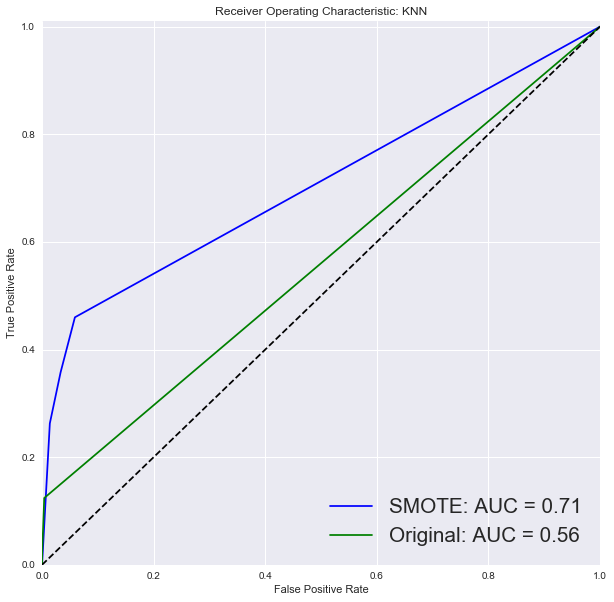

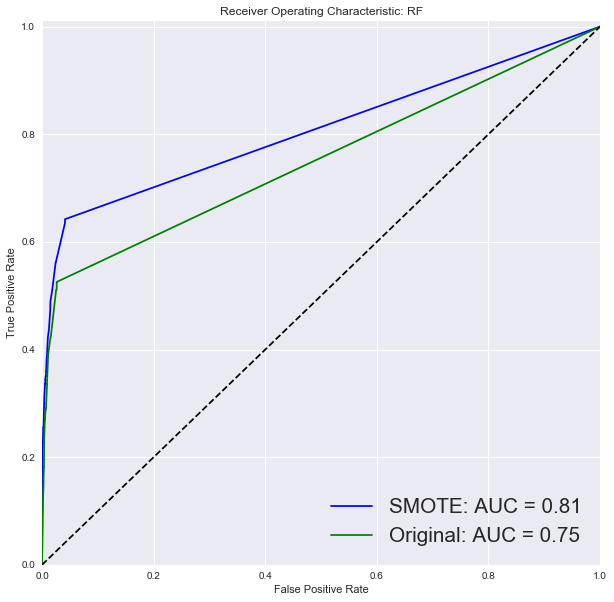

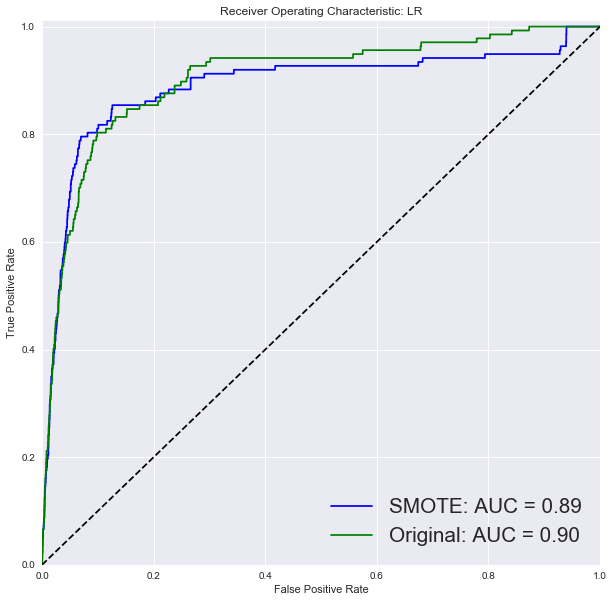

In [132]:
# plot the ROCs
for k in clf_dict.keys():
    plt.title('Receiver Operating Characteristic: ' + k.upper())

    plt.plot(clf_dict[k]['smote']['fpr'], clf_dict[k]['smote']['tpr'], 'b',label='SMOTE: AUC = %0.2f'% clf_dict[k]['smote']['auc'])
    plt.plot(clf_dict[k]['non-smote']['fpr'], clf_dict[k]['non-smote']['tpr'], 'g',label='Original: AUC = %0.2f'% clf_dict[k]['non-smote']['auc'])

    plt.legend(loc='lower right', fontsize="xx-large")
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0,1.0])
    plt.ylim([0,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Classification Task

### White-Box: Decision Tree

In [ ]:
# remove identifiers
temp = data_preproc.copy()
for x in data_preproc.columns:
    if data_preproc[x].dtypes == np.dtype('O'):
        temp = temp.drop([x], axis=1)
        
temp = temp.drop(['creationdate'], axis=1)
temp = temp.drop(['bin'], axis=1)
for column in temp.columns:
    if hasattr(temp[column], 'cat'):
        temp[column] = temp[column].cat.codes
        
labels = temp['is_fraud']
temp = temp.drop(['is_fraud'], axis=1)

feature_names = temp.columns

labels = np.array(labels)
temp = np.array(temp)

X_train, X_test, y_train, y_test = train_test_split(temp, labels, test_size=0.33, random_state=42)
# apply SMOTE
sm = SMOTE(ratio=0.9)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)


In [ ]:
from sklearn import tree

modelDT = tree.DecisionTreeClassifier();
modelDT = modelDT.fit(X_train, y_train)
# predict the response
pred = modelDT.predict(X_test)
# evaluate accuracy
recall = recall_score(y_test, pred)
precision = precision_score(y_test, pred)
accuracy = accuracy_score(y_test, pred)

print ('Precision before smoting - DT', precision) #0.035398230088495575
print ('Recall before smoting - DT', recall) #0.035398230088495575
print ('Accuracy before smoting -  DT', accuracy) #0.9972130602643757

modelDT.fit(X_train_res, y_train_res)
pred = modelDT.predict(X_test)
recalldt_smoting = recall_score(y_test, pred)
precision_smoting = precision_score(y_test, pred)
accuracydt_smoting = accuracy_score(y_test, pred)

print ('Precision after smoting - DT', precision_smoting) #0.035398230088495575
print ('Recall after smoting - DT', recalldt_smoting) #0.05309734513274336
print ('Accuracy after smoting -  DT', accuracydt_smoting) #0.9967911840658639

In [ ]:
#visualization of the 
import graphviz

dot_data = tree.export_graphviz(modelDT, out_file=None, 
                         feature_names=feature_names,  
                         class_names=['Legitimate', 'Fraud'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("decision_tree_fraud")